In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import pickle


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_statistics = pd.read_csv("Statistics.csv")

In [ ]:
df_statistics

,Unnamed: 0,pickup_hour,pickup_location,dropoff_location,trip_distance,trip_time_in_secs,total_amount,number_of_transitions,count,counts,transition_probability
0,0,0.0,7002,7002,1.660000,420.000000,44.500000,2,2.0,2,1.000000
1,1,0.0,7008,7008,2.230000,660.000000,11.000000,1,1.0,1,1.000000
2,2,0.0,7011,7011,0.000000,0.000000,5.000000,1,1.0,1,1.000000
3,3,0.0,7017,10018,3.420000,1500.000000,19.000000,1,1.0,1,1.000000
4,4,0.0,7020,10003,7.610000,1500.000000,32.900000,1,8.0,8,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
71914,71914,23.0,97003,10020,1.340000,420.000000,8.000000,1,NaN,546,0.001832
71915,71915,23.0,97003,10065,1.510000,300.000000,7.500000,1,NaN,546,0.001832
71916,71916,23.0,97003,11024,0.000000,0.000000,110.400000,1,NaN,546,0.001832
71917,71917,23.0,97003,11211,3.640000,1020.000000,16.000000,1,NaN,546,0.001832


In [ ]:
listed_pickup_zipcodes = df_statistics['pickup_location'].unique()
listed_dropoff_zipcodes = df_statistics['dropoff_location'].unique()

zipcodes = list(set([*listed_pickup_zipcodes, *listed_dropoff_zipcodes]))

In [ ]:
class CabDriver():
    def __init__(self, cost, zipcodes):
        self.t = 24
        self.m = 60
        self.zipcode_count = len(zipcodes)
        self.zipcodes = zipcodes
        self.action_space = [(p,q) for p in zipcodes for q in zipcodes]
        self.action_space.insert(0,(-1,-1))
        self.state_space = [(x,z, y) for x in range(self.t) for z in range(self.m) for y in zipcodes]
        self.state_init = self.state_space[np.random.choice(len(self.state_space))]
        self.cost = cost
        self.reset()

    def state_encoder(self, state):
        curr_hour,curr_min, curr_loc= state

        ## Initialize arrays
        state_encodings = np.zeros(self.zipcode_count+self.t+self.m, dtype=int)
        state_encodings[self.zipcodes.index(curr_loc)] = 1
        state_encodings[self.zipcode_count+curr_hour] = 1
        state_encodings[self.zipcode_count+self.t+ curr_min] = 1

        return state_encodings

    def requests(self, state):
        curr_hour,_, curr_loc= state
        actions_in_hour = [tuple(x)for x in df_statistics[(df_statistics["pickup_hour"]==curr_hour)].sort_values(by=["total_amount"],ascending=False)[["pickup_location","dropoff_location"]].head(10).to_records(index=False)]
        # requests = np.random.poisson(10)
        # possible_actions = random.sample(actions_in_hour, requests) + [(-1,-1)]
        return actions_in_hour

    def update_time(self, curr_hour, curr_minute, ride_duration):
        ride_duration = int(ride_duration)
        curr_second =  curr_hour * 3600 + curr_minute * 60 + ride_duration
        m, s = divmod(curr_second, 60)
        h, m = divmod(m, 60)
        return h, m

    def get_duration(self, curr_hour, pickup_loc, dropoff_loc):
        temp = df_statistics[(df_statistics["pickup_hour"]==curr_hour) & (df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          temp = df_statistics[(df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          return 15*60; # max duration is 15 minutes for a pickup
        else:
          return temp["trip_time_in_secs"].mean()

    def get_reward(self, curr_hour, pickup_loc, dropoff_loc):
        temp = df_statistics[(df_statistics["pickup_hour"]==curr_hour) & (df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          temp = df_statistics[(df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          return 0; # max duration is 15 minutes for a pickup
        else:
          return temp["total_amount"].mean()

    def get_next_state_and_time_func(self, state, action):
        next_state = []

        # Initialize various times
        total_time   = 0
        transit_time = 0
        wait_time = 0
        ride_time    = 0

        curr_hour,curr_min, curr_loc = state
        pickup_loc, drop_loc= action

        """
         3 Possible Scenarios:
           i) Refuse all requests. Engage in Idle Time (wait: 1hr (i.e. 1 time unit))
           ii) Driver is already at the pickup spot
           iii) Driver is not at the pickup spot
        """
        if ((pickup_loc== -1) and (drop_loc == -1)):
            wait_time = 3600
            next_loc = curr_loc
            reward = 0
        elif (curr_loc == pickup_loc):
            ride_time = self.get_duration(curr_hour, pickup_loc, drop_loc)
            next_loc = drop_loc
            reward = self.get_reward(curr_hour, pickup_loc, drop_loc)
        else:
            transit_time      = self.get_duration(curr_hour,curr_loc, pickup_loc)
            new_hour, new_min = self.update_time(curr_hour,curr_min, transit_time)

            ride_time = self.get_duration(curr_hour, pickup_loc, drop_loc)
            next_loc  = drop_loc
            reward = self.get_reward(curr_hour, pickup_loc, drop_loc)

        # Calculate total time as sum of all durations
        total_time = (wait_time + transit_time + ride_time)
        next_hour, next_min = self.update_time(curr_hour, curr_min, total_time)

        # Finding next_state using the next_loc and the next time states.
        next_state = (next_hour, next_min, next_loc)

        return next_state,reward, wait_time, transit_time, ride_time

    def reward_func(self, reward, wait_time, transit_time, ride_time):
        """Takes in state, action and Time-matrix and returns the reward"""
        if wait_time + transit_time > 0:
            reward = reward - self.cost

        return reward

    def step(self, state, action):
        """
        Take a trip as cabby to get rewards next step and total time spent
        """
        # Get the next state and the various time durations
        next_state,reward, wait_time, transit_time, ride_time = self.get_next_state_and_time_func(state, action)
        # print(next_state,reward, wait_time, transit_time, ride_time)

        rewards = self.reward_func(reward, wait_time, transit_time, ride_time)
        total_time = wait_time + transit_time + ride_time

        return rewards, next_state, total_time

    def reset(self):
        return self.action_space, self.state_space, self.state_init


In [ ]:
class QLearningAgent():
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state, available_actions):
      """Choose an action based on the state using an epsilon-greedy policy."""
      if np.random.rand() <= self.epsilon:
          return random.choice(available_actions)
      else:
          q_values = self.q_table[state, :]
          max_value = np.max(q_values[available_actions])
          best_actions = [action for action in available_actions if q_values[action] == max_value]
          return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule."""
        # Getting prediction
        predict = self.q_table[state, action]
        # We assume all actions are available for the next state for simplification
        target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - predict)

    def update_epsilon(self):
        """Update epsilon using exponential decay to reduce the exploration rate over time."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
episode_time = 24*60*60
n_episodes = 5000
max_steps = 200
env = CabDriver(zipcodes=zipcodes, cost = 3)
action_space, state_space, state = env.reset()

state_size = len(state_space)
print(state_size)
action_size = len(action_space)
print(action_size)

# Invoke agent class
q_learning_agent = QLearningAgent(state_size=state_size, action_size=action_size)
q_learning_rewards_per_episode, episodes = [], []

def state_to_index(state, t=24, m=60, zipcodes=None):
    hour, minute, location = state
    location_index = zipcodes.index(location) if zipcodes is not None and location in zipcodes else location
    return hour * (m * len(zipcodes)) + minute * len(zipcodes) + location_index

898560
389377


In [ ]:
for episode in range(n_episodes):
    _, _, q_learning_state = env.reset()
    q_learning_score = 0

    for step in range(max_steps):

      available_actions = env.requests(q_learning_state)
      state_index = state_to_index(q_learning_state, zipcodes=env.zipcodes)
      available_action_indices = [env.action_space.index(action) for action in available_actions]
      q_learning_action = q_learning_agent.choose_action(state_index, available_action_indices)

      q_learning_reward, q_learning_next_state, _ = env.step(q_learning_state, env.action_space[q_learning_action])
      q_learning_next_state_hour, q_learning_next_state_min, _ = q_learning_next_state

      # Day is over
      if (q_learning_next_state_hour * 3600 + q_learning_next_state_min * 60 >= episode_time):
          break

      next_state_index = state_to_index(q_learning_next_state, zipcodes=env.zipcodes)

      q_learning_agent.update_q_value(state_index, q_learning_action,
                                   q_learning_reward, next_state_index)

      q_learning_state = q_learning_next_state
      q_learning_score += q_learning_reward

    q_learning_rewards_per_episode.append(q_learning_score)
    q_learning_agent.update_epsilon()

    if episode % 100 == 0:
        print(f"Q-learning Episode {episode}: Reward = {q_learning_score}")
        # sarsa_agent.save(f'sarsa_q_table_{episode}.npy')

Q-learning Episode 0: Reward = 759.78
Q-learning Episode 100: Reward = 703.4
Q-learning Episode 200: Reward = 1129.35
Q-learning Episode 300: Reward = 999.25
Q-learning Episode 400: Reward = 1252.8999999999999
Q-learning Episode 500: Reward = 1209.66
Q-learning Episode 600: Reward = 1068.31
Q-learning Episode 700: Reward = 1068.31
Q-learning Episode 800: Reward = 1068.31
Q-learning Episode 900: Reward = 1068.31
Q-learning Episode 1000: Reward = 1068.31
Q-learning Episode 1100: Reward = 1068.31
Q-learning Episode 1200: Reward = 1010.6500000000001
Q-learning Episode 1300: Reward = 1068.31
Q-learning Episode 1400: Reward = 1068.31
Q-learning Episode 1500: Reward = 1068.31
Q-learning Episode 1600: Reward = 1068.31
Q-learning Episode 1700: Reward = 1068.31
Q-learning Episode 1800: Reward = 1068.31
Q-learning Episode 1900: Reward = 1068.31
Q-learning Episode 2000: Reward = 1068.31
Q-learning Episode 2100: Reward = 1068.31
Q-learning Episode 2200: Reward = 1068.31
Q-learning Episode 2300: Rew

Text(0.5, 1.0, 'Rewards per Episode')

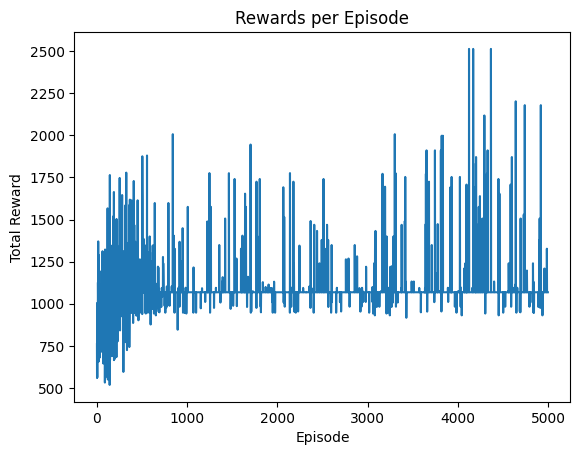

In [ ]:
plt.plot(range(5000), q_learning_rewards_per_episode, label="Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode")

In [ ]:
print(f"Q-Learning mean: {np.mean(q_learning_rewards_per_episode)}, std: {np.std(q_learning_rewards_per_episode)}")

Q-Learning mean: 1074.5356619999998, std: 112.91775818976284
